In [3]:
# ============================================
# CNN + U-NET HYBRID IMAGE COLORIZATION MODEL (Updated Decoder + ResNet18)
# ============================================

# ✅ Part 0: Install Required Libraries (only for Jupyter)
!pip install torch torchvision matplotlib scikit-image tqdm opencv-python

# ✅ Part 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import numpy as np
import os, glob
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from tqdm import tqdm
import matplotlib.pyplot as plt

# ✅ Part 2: Dataset Loader
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images=100):
        self.image_paths = glob.glob(os.path.join(root_dir, '**/*.jpg'), recursive=True)[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = img.resize((256, 256))
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        L = img_lab[:, :, 0] / 100.0
        ab = img_lab[:, :, 1:] / 128.0
        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2, 0, 1)
        return L, ab

# ✅ Part 3: CNN + U-Net Hybrid Model (Updated Decoder)
class CNNUNetColorization(nn.Module):
    def __init__(self):
        super(CNNUNetColorization, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove last FC layers
        self.encoder[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Updated Decoder with extra upsampling layer for 256x256 output
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # 8→16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 16→32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # 32→64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # 64→128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),    # 128→256 ✅ NEW
            nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=3, padding=1),            # Final output
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ✅ Part 4: Training Setup
train_dataset = ColorizationDataset("dataset/sample_images", max_images=100)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

model = CNNUNetColorization().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ Part 5: Training Loop
for epoch in range(5):
    model.train()
    running_loss = 0
    for L, ab in tqdm(train_loader):
        L, ab = L.cuda(), ab.cuda()
        optimizer.zero_grad()
        output = model(L)
        loss = criterion(output, ab)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/5] - Loss: {running_loss/len(train_loader):.4f}")

# ✅ Part 6: Evaluation Function
def show_colorized_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img = np.array(img)
    lab = rgb2lab(img).astype("float32")
    L = lab[:, :, 0] / 100.0
    L_tensor = torch.from_numpy(L).unsqueeze(0).unsqueeze(0).cuda()

    with torch.no_grad():
        ab_pred = model(L_tensor).cpu().squeeze().permute(1, 2, 0).numpy()

    ab_pred = ab_pred * 128.0
    L = L * 100.0
    lab_pred = np.concatenate((L[:, :, None], ab_pred), axis=2)
    rgb_pred = lab2rgb(lab_pred)

    plt.imshow(rgb_pred)
    plt.axis('off')
    plt.title('Colorized Output')
    plt.show()

# ✅ Part 7: Test Call
# show_colorized_image(model, "dataset/sample_images/Flicker8k_Dataset/sample.jpg")


100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  6.34it/s]


Epoch [1/5] - Loss: 0.0169


100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.48it/s]


Epoch [2/5] - Loss: 0.0148


100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.48it/s]


Epoch [3/5] - Loss: 0.0134


100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.50it/s]


Epoch [4/5] - Loss: 0.0127


100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.48it/s]

Epoch [5/5] - Loss: 0.0127


In [5]:
import os

image_dir = "dataset/sample_images/Flicker8k_Dataset"
images = os.listdir(image_dir)
print(images[:10])  # show first 10 image names


['3546027589_253553252a.jpg', '2612488996_9450de0e54.jpg', '124972799_de706b6d0b.jpg', '2518508760_68d8df7365.jpg', '1396064003_3fd949c9dd.jpg', '3649382413_58a4b1efe8.jpg', '3407584080_c6abf71ae3.jpg', '319870744_0e0138d205.jpg', '2856699493_65edef80a1.jpg', '276356412_dfa01c3c9e.jpg']


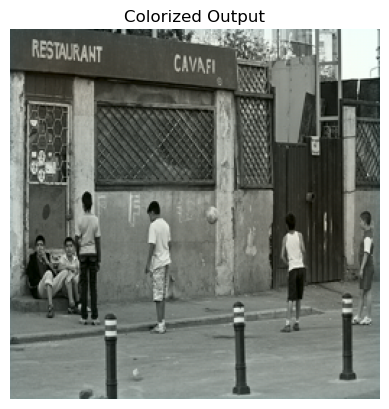

In [6]:
show_colorized_image(model, "dataset/sample_images/Flicker8k_Dataset/3546027589_253553252a.jpg")


In [7]:
# ============================================
# U-NET + RESNET50 HYBRID IMAGE COLORIZATION
# ============================================

# ✅ Part 1: Imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os, glob
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
import matplotlib.pyplot as plt

# ✅ Part 2: Dataset Loader
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, max_images=100):
        self.image_paths = glob.glob(os.path.join(root_dir, '**/*.jpg'), recursive=True)[:max_images]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB").resize((256, 256))
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        L = img_lab[:, :, 0] / 100.0
        ab = img_lab[:, :, 1:] / 128.0
        L = torch.from_numpy(L).unsqueeze(0).float()
        ab = torch.from_numpy(ab).permute(2, 0, 1).float()
        return L, ab

# ✅ Part 3: ResNet50 + U-Net Decoder Hybrid Model
class ResNetUNet(nn.Module):
    def __init__(self):
        super(ResNetUNet, self).__init__()
        resnet = models.resnet50(pretrained=True)

        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # (B, 2048, 8, 8)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Convert grayscale to 3 channels by repeating
        x3 = x.repeat(1, 3, 1, 1)
        features = self.encoder(x3)
        output = self.decoder(features)
        return output

# ✅ Part 4: Training Setup
dataset_path = "dataset/sample_images/Flicker8k_Dataset"
train_dataset = ColorizationDataset(dataset_path, max_images=500)  # You can increase image count now
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

model = ResNetUNet().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ Part 5: Training Loop
epochs = 20  # 🔼 Increased epochs for better learning
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for L, ab in tqdm(train_loader):
        L, ab = L.cuda(), ab.cuda()
        optimizer.zero_grad()
        output = model(L)
        output = torch.nn.functional.interpolate(output, size=(256, 256), mode='bilinear')
        loss = criterion(output, ab)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"✅ Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# ✅ Part 6: Evaluation
def show_colorized_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img)
    lab = rgb2lab(img_np).astype("float32")
    L = lab[:, :, 0] / 100.0
    L_tensor = torch.from_numpy(L).unsqueeze(0).unsqueeze(0).cuda()

    with torch.no_grad():
        ab_pred = model(L_tensor)
        ab_pred = torch.nn.functional.interpolate(ab_pred, size=(256, 256), mode='bilinear')
        ab_pred = ab_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    ab_pred = ab_pred * 128.0
    L = L * 100.0
    lab_output = np.concatenate((L[:, :, None], ab_pred), axis=2)
    rgb_output = lab2rgb(lab_output)

    plt.imshow(rgb_output)
    plt.axis('off')
    plt.title("🌈 Colorized Output")
    plt.show()

# Test on an image
# show_colorized_image(model, "dataset/sample_images/Flicker8k_Dataset/your_image.jpg")


/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/a.kanamarlapudi001/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|███████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 109MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.97it/s]


✅ Epoch 1/20, Loss: 0.0131


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.50it/s]


✅ Epoch 2/20, Loss: 0.0119


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.49it/s]


✅ Epoch 3/20, Loss: 0.0103


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.36it/s]


✅ Epoch 4/20, Loss: 0.0100


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.50it/s]


✅ Epoch 5/20, Loss: 0.0085


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.50it/s]


✅ Epoch 6/20, Loss: 0.0081


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.50it/s]


✅ Epoch 7/20, Loss: 0.0074


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.36it/s]


✅ Epoch 8/20, Loss: 0.0073


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.49it/s]


✅ Epoch 9/20, Loss: 0.0068


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.50it/s]


✅ Epoch 10/20, Loss: 0.0066


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.51it/s]


✅ Epoch 11/20, Loss: 0.0064


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.38it/s]


✅ Epoch 12/20, Loss: 0.0060


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.51it/s]


✅ Epoch 13/20, Loss: 0.0058


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.50it/s]


✅ Epoch 14/20, Loss: 0.0056


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.49it/s]


✅ Epoch 15/20, Loss: 0.0054


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.36it/s]


✅ Epoch 16/20, Loss: 0.0052


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.52it/s]


✅ Epoch 17/20, Loss: 0.0051


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.51it/s]


✅ Epoch 18/20, Loss: 0.0049


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.37it/s]


✅ Epoch 19/20, Loss: 0.0048


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.50it/s]

✅ Epoch 20/20, Loss: 0.0046


In [9]:
show_colorized_image(model, "dataset/sample_images/Flicker8k_Dataset/your_image.jpg")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/sample_images/Flicker8k_Dataset/your_image.jpg'

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


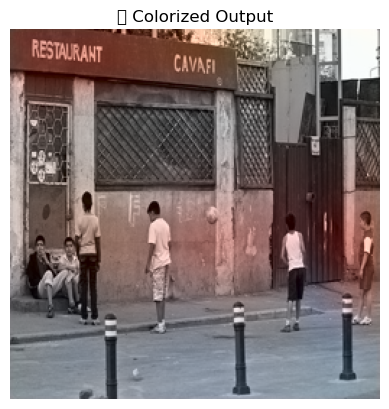

In [10]:
show_colorized_image(model, "dataset/sample_images/Flicker8k_Dataset/3546027589_253553252a.jpg")


Epoch [1/10] | Train Loss: 0.0121 | Val Loss: 0.0114
Epoch [2/10] | Train Loss: 0.0112 | Val Loss: 0.0110
Epoch [3/10] | Train Loss: 0.0104 | Val Loss: 0.0109
Epoch [4/10] | Train Loss: 0.0095 | Val Loss: 0.0110
Epoch [5/10] | Train Loss: 0.0086 | Val Loss: 0.0109
Epoch [6/10] | Train Loss: 0.0076 | Val Loss: 0.0111
Epoch [7/10] | Train Loss: 0.0069 | Val Loss: 0.0110
Epoch [8/10] | Train Loss: 0.0063 | Val Loss: 0.0114
Epoch [9/10] | Train Loss: 0.0059 | Val Loss: 0.0111
Epoch [10/10] | Train Loss: 0.0055 | Val Loss: 0.0108


/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


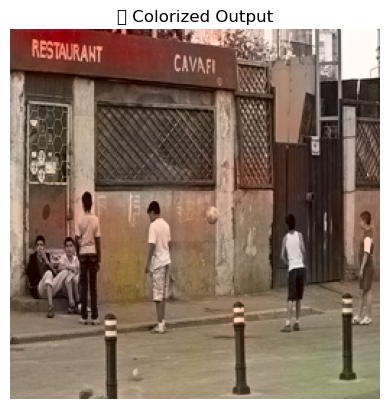

In [13]:
# ===============================================
# IMAGE COLORIZATION - U-Net + ResNet50 Hybrid
# ===============================================

# ✅ Part 1: Imports
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# ✅ Part 2: Dataset Split - 70% Train, 15% Val, 15% Test
image_paths = glob.glob("dataset/sample_images/Flicker8k_Dataset/*.jpg")
train_paths, temp_paths = train_test_split(image_paths, test_size=0.3, random_state=42)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

# Save splits (optional)
with open("train_images.txt", "w") as f: f.writelines('\n'.join(train_paths))
with open("val_images.txt", "w") as f: f.writelines('\n'.join(val_paths))
with open("test_images.txt", "w") as f: f.writelines('\n'.join(test_paths))

# ✅ Part 3: Dataset Loader
class ColorizationDataset(Dataset):
    def __init__(self, image_list_path, transform=None):
        with open(image_list_path, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB").resize((256, 256))
        if self.transform: img = self.transform(img)
        img = np.array(img)
        lab = rgb2lab(img).astype("float32")
        L = lab[:, :, 0] / 100.0
        ab = lab[:, :, 1:] / 128.0
        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2, 0, 1)
        return L, ab

# ✅ Part 4: Model Architecture - ResNet50 Encoder + U-Net Decoder
class UNetResNet50(nn.Module):
    def __init__(self):
        super(UNetResNet50, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc_out = self.encoder(x.repeat(1, 3, 1, 1))  # Convert (1 channel) → (3 channels)
        dec_out = self.decoder(enc_out)
        return dec_out

# ✅ Part 5: Data Loaders
train_dataset = ColorizationDataset("train_images.txt")
val_dataset = ColorizationDataset("val_images.txt")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# ✅ Part 6: Training Setup
model = UNetResNet50().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ Part 7: Training Loop (10 Epochs)
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for L, ab in train_loader:
        L, ab = L.cuda(), ab.cuda()
        optimizer.zero_grad()
        output = model(L)
        output = F.interpolate(output, size=ab.shape[2:], mode='bilinear')
        loss = criterion(output, ab)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for L, ab in val_loader:
            L, ab = L.cuda(), ab.cuda()
            output = model(L)
            output = F.interpolate(output, size=ab.shape[2:], mode='bilinear')
            loss = criterion(output, ab)
            val_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10] | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

# ✅ Part 8: Visualization
def show_colorized_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img)
    lab = rgb2lab(img_np).astype("float32")
    L = lab[:, :, 0] / 100.0
    L_tensor = torch.from_numpy(L).unsqueeze(0).unsqueeze(0).cuda()

    with torch.no_grad():
        ab_pred = model(L_tensor)
        ab_pred = F.interpolate(ab_pred, size=(256, 256), mode='bilinear')
        ab_pred = ab_pred.cpu().squeeze().permute(1, 2, 0).numpy()

    ab_pred *= 128.0
    L *= 100.0
    lab_combined = np.concatenate((L[:, :, None], ab_pred), axis=2)
    rgb_out = lab2rgb(lab_combined)

    plt.imshow(rgb_out)
    plt.axis('off')
    plt.title("🎨 Colorized Output")
    plt.show()

# ✅ Part 9: Test the Model
# Example test:
show_colorized_image(model, "dataset/sample_images/Flicker8k_Dataset/3546027589_253553252a.jpg")


In [12]:
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 72.2 MB/s eta 0:00:0000:01
